# Objective

We are going to build decision trees with varying depths. Then we will use cross validation to determine which depth has the best ability to generalise to new data, whilst reducing the amount of overfitting.

In [1]:
import pandas as pd
import numpy as np
from decision_tree import DecisionTree
from decision_tree_evaluator import DecisionTreeEvaluator
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Credit_card_dataset.csv")

In [3]:
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,approved_status
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.drop("Ind_ID", inplace=True, axis=1)

In [6]:
bins = 10
df["Annual_income"] = pd.cut(df["Annual_income"], bins=bins)
df["Birthday_count"] = pd.cut(df["Birthday_count"], bins=bins)
df["Employed_days"] = pd.cut(df["Employed_days"], bins=bins)

In [7]:
label_encoder = LabelEncoder()
df["Annual_income"] = label_encoder.fit_transform(df["Annual_income"])
df["Birthday_count"] = label_encoder.fit_transform(df["Birthday_count"])
df["Employed_days"] = label_encoder.fit_transform(df["Employed_days"])

In [8]:
df.head()

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,approved_status
0,M,Y,Y,1,2,Commercial associate,Secondary / secondary special,Married,House / apartment,3,9,1,0,1,1,Core staff,3,1
1,M,Y,Y,1,2,Pensioner,Secondary / secondary special,Married,House / apartment,3,9,1,0,1,1,Core staff,3,1
2,M,Y,Y,1,2,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,3,9,1,0,1,1,Core staff,1,1
3,F,Y,Y,0,0,Working,Secondary / secondary special,Married,House / apartment,3,9,1,1,1,0,Cooking staff,2,1
4,F,Y,Y,0,0,Working,Secondary / secondary special,Married,House / apartment,3,9,1,1,1,0,Cooking staff,2,1


In [9]:
features = df.drop("approved_status", axis=1)
Class = df["approved_status"]

In [10]:
class_names = {0: "denied", 1: "accepted"}

In [11]:
X, y = pd.get_dummies(features), Class  # one hot encoded

This decision tree is constructed by linked `Node` objects whereby each node contains a `feature` and `split_value` attribute which are used in the testing phase. The depth of the decision tree is determined by `stopping_depth`.

In [12]:
tm = DecisionTree()

By splitting the data into training and test data, we can train our model on the training data, and then simulate how well it will generalise to new data, by testing it on the test data. It will be randomly shuffled before splitting so as to ensure that the model doesn't accidentally detect a "phantom" order relationship, that may be an artifact of the dataset, and not represent reality.

In [13]:
X_train, X_test, y_train, y_test = tm.train_test_split(X, y, train_frac=0.8, random_state=42)  # 80/20 split

In [14]:
depths = list(range(1, 21))  # depths we are interested in

In [15]:
tm.display_tree(tm.train(X, y), "full_tree", class_names=class_names, pop_up=False)

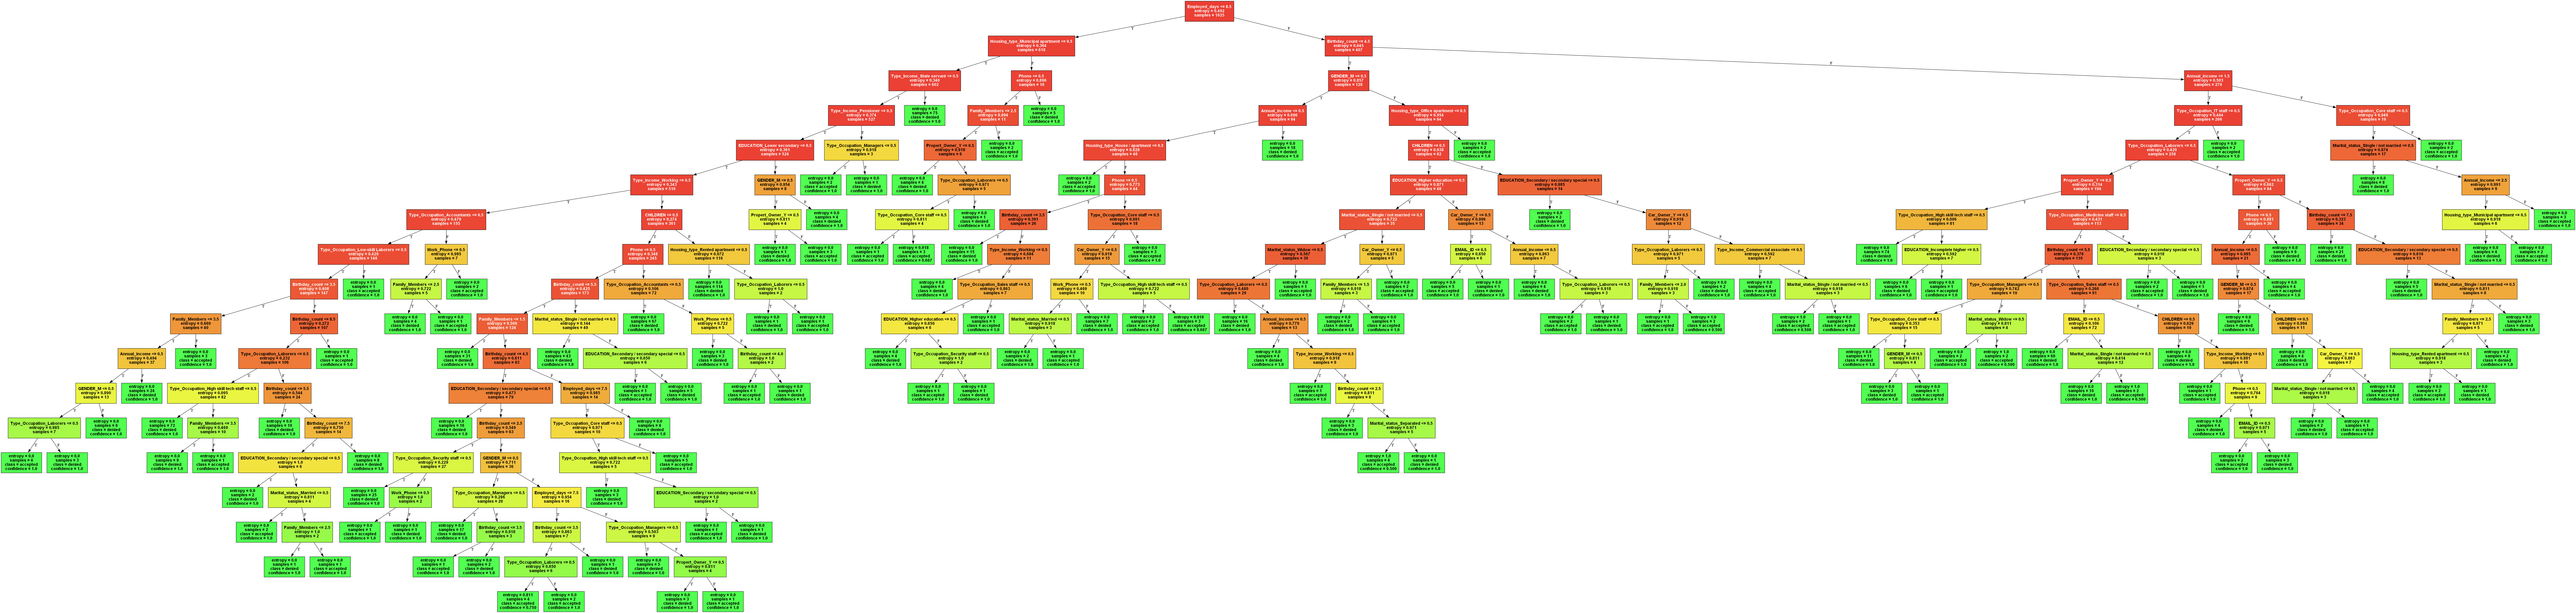

When depth is allowed to expand to completion, the tree becomes massive in size. This indicates that the decision tree is struggling to make meaningful splits.

Now we will evaluate our trees. The metric will be P-R. This metric is being used because the class is fairly unbalanced after we removed the null values. P-R is suggested for imbalanced datasets, whereas ROC is recommended for balanced datasets.

In [16]:
tm_eval = DecisionTreeEvaluator(curve="P-R")

We want to properly evaluate the performance of our decision trees. To do this, we will perform 5-fold cross validation with the P-R metric on each of our decision trees, and compare performance.

First we split the data into k-folds (5 for this implementation). Each split contains the training and testing datasets. Next we use the training data to train our decision tree, and then evaluate it with the testing data, and a preferred metric. In this case we are using the P-R, or precision-recall curve metric. We will return both the AUC as a quantifier and the P-R curve itself to visually see what’s going on as the depth increases. At the end, we average the performance of the k-folds to obtain a single measure that reflects the overall performance of the decision tree algorithm.

In [17]:
cv_results = [tm_eval.cross_validate(tm, X, y, depth, threshold_step_size=0.01, k_folds=5, random_state=42) for depth in depths]

In [18]:
y_predictions = [tm_eval.test(tm.train(X_train, y_train, stopping_depth=depth), X_test) for depth in depths]
accuracies = [tm_eval.accuracy(y_test, prediction) for prediction in y_predictions]
mean_train_auc = [np.mean(cv["train_auc"]) for cv in cv_results]
mean_test_auc = [np.mean(cv["test_auc"]) for cv in cv_results]

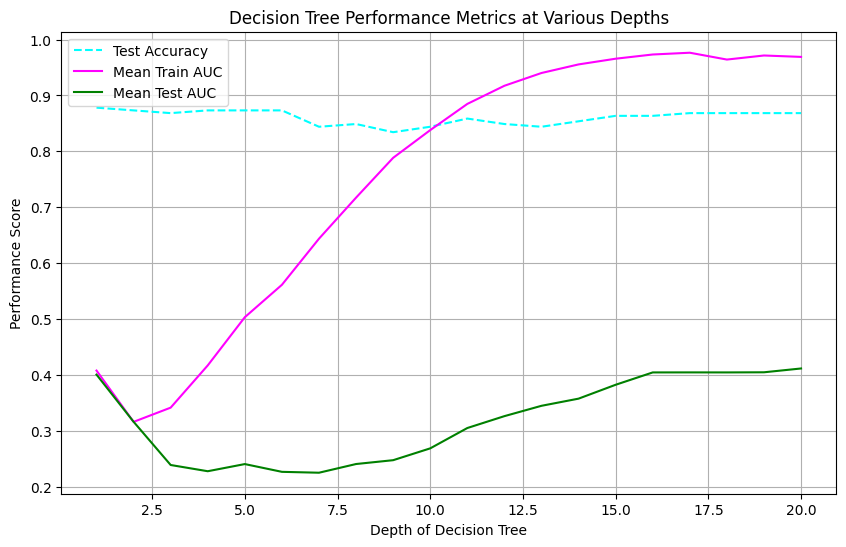

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, label="Test Accuracy", color="cyan", linestyle="--")
plt.plot(depths, mean_train_auc, label="Mean Train AUC", color="magenta")
plt.plot(depths, mean_test_auc, label="Mean Test AUC", color="green")
plt.xlabel("Depth of Decision Tree")
plt.ylabel("Performance Score")
plt.title("Decision Tree Performance Metrics at Various Depths")
plt.legend()
plt.grid(True)
plt.show()

The graph delineates performance issues of a decision tree classifier as the depth augments, with test accuracy reaching a plateau and subsequently diminishing, indicative of overfitting beyond a depth of 5. The model exhibits a propensity for adapting excessively to the training data, as illustrated by the Mean Train AUC approaching 1, failing to translate into enhanced predictive accuracy for new data. This disparity between training and test outcomes accentuates the model's constrained capability to generalise, achieving balanced performance solely at shallower depths where it is less prone to assimilating noise.

These patterns imply that the decision tree may not be the most apt model for the dataset, struggling to generalise with increased complexity. It highlights the need for alternative approaches such as ensemble methods, which could better encapsulate the dataset's intricacies without succumbing to overfitting. In tandem, it is pivotal to revisit the preprocessing and feature engineering processes to ensure data quality, potentially improving model performance without necessitating additional complexity.